In [232]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch

from Net.experiments.main_experiments import TrainExperiment, KP1, KP2, W_KP1, W_KP2, KP1_DESC, KP2_DESC, DESC1, DESC2
from Net.source.utils.common_utils import draw_cv_keypoints, torch2cv
from Net.source.utils.model_utils import sample_descriptors
from Net.source.utils.math_utils import calculate_inv_similarity_matrix, calculate_distance_matrix, calculate_inv_similarity_vector
from Net.source.utils.image_utils import create_coordinates_grid
from Net.source.hpatches_dataset import S_IMAGE1, S_IMAGE2, HOMO12, HOMO21


In [234]:
device = torch.device('cpu')

checkpoint_dir = "/home/konstantin/PycharmProjects/Summertime/Net/checkpoints/train_num_neigh9"

experiment = TrainExperiment(device, None, checkpoint_dir, 3000)

In [235]:
batch = experiment.analyze_inference()

In [236]:
def plot_figures(figures, nrows = 1, ncols=1, size=None):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=size)
    for ind, title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        
    plt.tight_layout() # optional

In [316]:
cv_s_image1 = torch2cv(batch[S_IMAGE1].squeeze(0))
cv_s_image2 = torch2cv(batch[S_IMAGE2].squeeze(0))

kp1 = batch[KP1]
kp2 = batch[KP2]

w_kp1 = batch[W_KP1]
w_kp2 = batch[W_KP2]

kp1_desc = batch[KP1_DESC]
kp2_desc = batch[KP2_DESC]

desc1 = batch[DESC1]
desc2 = batch[DESC2]

In [317]:
num_neg = 1
grid_size = 8
num_neigh = 25
margin = 1
loss_lambda = 1


b, n, c = kp1_desc.size()

w_kp1_desc = sample_descriptors(desc2, w_kp1, grid_size)

# Take positive matches
positive_sim = calculate_inv_similarity_vector(kp1_desc, w_kp1_desc)
positive_sim = positive_sim.view(b, n, 1).repeat(1, 1, num_neg).view(b, n * num_neg)

# Create neighbour mask
kp_grid = w_kp1[:, :, [1, 0]]
coo_grid = create_coordinates_grid(desc2).view(b, -1, 2).to(desc2.device)
coo_grid = coo_grid * grid_size + grid_size // 2

grid_dist = calculate_distance_matrix(kp_grid, coo_grid)
_, ids = grid_dist.topk(k=num_neigh, largest=False, dim=-1)

mask = torch.zeros_like(grid_dist).to(grid_dist.device)
mask = mask.scatter(dim=-1, index=ids, value=1)

# Calculate similarity
# TODO. REstore
desc2 = desc2.permute((0, 2, 3, 1)).view(b, -1, c)
desc_sim = calculate_inv_similarity_matrix(kp1_desc, desc2)

# Apply neighbour mask and get negatives
desc_sim = desc_sim + mask * 5

neg_sim = desc_sim.topk(k=num_neg, dim=-1, largest=False)[0].view(b, -1)

fos = (torch.clamp(positive_sim - neg_sim + margin, min=0) ** 2).mean()

sos_neg = 4

kp1_sim = calculate_inv_similarity_matrix(kp1_desc, kp1_desc)
kp1_mask = (calculate_distance_matrix(kp1, kp1) <= radius).float()

w_kp1_sim = calculate_inv_similarity_matrix(w_kp1_desc, w_kp1_desc)
w_kp1_mask = (calculate_distance_matrix(w_kp1, w_kp1) <= radius).float()

kp1_sim += kp1_mask * 5
w_kp1_sim += w_kp1_mask * 5

_, kp1_neg_ids = kp1_sim.topk(k=sos_neg, dim=-1, largest=False)
_, w_kp1_neg_ids = w_kp1_sim.topk(k=sos_neg, dim=-1, largest=False)

kp1_neg_ids = kp1_neg_ids.view(b, n * sos_neg).unsqueeze(-1).repeat(1, 1, c)
w_kp1_neg_ids = w_kp1_neg_ids.view(b, n * sos_neg).unsqueeze(-1).repeat(1, 1, c)

kp1_neg_desc = kp1_desc.gather(dim=1, index=kp1_neg_ids)
w_kp1_neg_desc = w_kp1_desc.gather(dim=1, index=w_kp1_neg_ids)

kp1_desc = kp1_desc.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, n * sos_neg, c)
w_kp1_desc = w_kp1_desc.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, n * sos_neg, c)

sos = calculate_inv_similarity_vector(kp1_desc, kp1_neg_desc) - calculate_inv_similarity_vector(w_kp1_desc, w_kp1_neg_desc)
sos = (sos ** 2).view(b, n, sos_neg).sum(-1).sqrt().mean()

loss = (fos + sos) * loss_lambda

loss

tensor(1.4173)

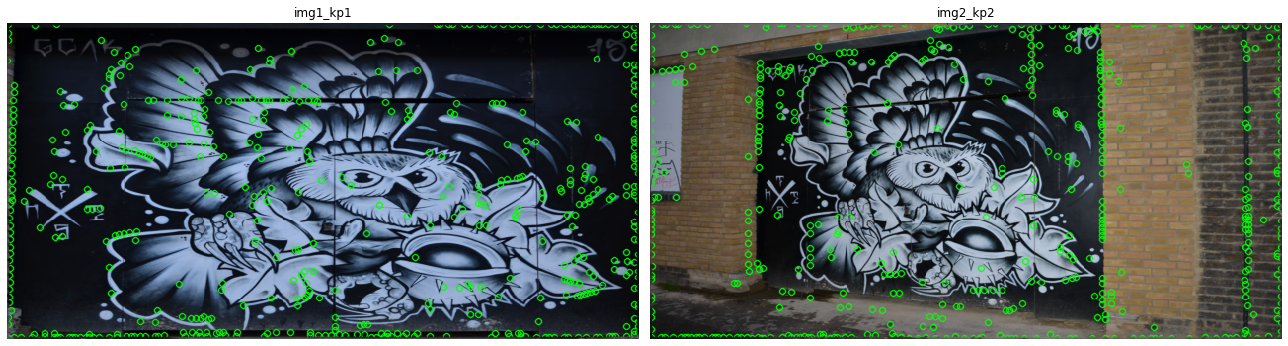

In [238]:
cv_kp1_image = draw_cv_keypoints(cv_s_image1, kp1.squeeze(0), (0, 255, 0))
cv_kp2_image = draw_cv_keypoints(cv_s_image2, kp2.squeeze(0), (0, 255, 0))

plot_figures({'img1_kp1': cv_kp1_image,
              'img2_kp2': cv_kp2_image}, 1, 2, (18, 9))

In [239]:
w_kp1_desc = sample_descriptors(desc2, w_kp1, 8)

radius = 3 * 8 * np.sqrt(2)

# TODO. This neighbour mask should also follow the rules of warping. But only after everything would be tested

anchor_sim = calculate_inv_similarity_matrix(kp1_desc, kp1_desc)
anchor_mask = (calculate_distance_matrix(kp1, kp1) <= radius).float()

anchor_sim += anchor_mask * 5

_, anchor_ids = anchor_sim.topk(k=4, dim=-1, largest=False)

positive_sim = calculate_inv_similarity_matrix(w_kp1_desc, w_kp1_desc)
positive_mask = (calculate_distance_matrix(w_kp1, w_kp1) <= radius).float()

positive_sim += positive_mask * 5

_, positive_ids = positive_sim.topk(k=4, dim=-1, largest=False)

In [240]:
kp_id = 100
kp1_closest = kp1[0, anchor_mask[0, kp_id].nonzero()].squeeze(1)
w_kp1_closest = w_kp1[0, positive_mask[0, kp_id].nonzero()].squeeze(1)

kp1_hardest = kp1[0, anchor_ids[0, kp_id]]
w_kp1_hardest = w_kp1[0, positive_ids[0, kp_id]]

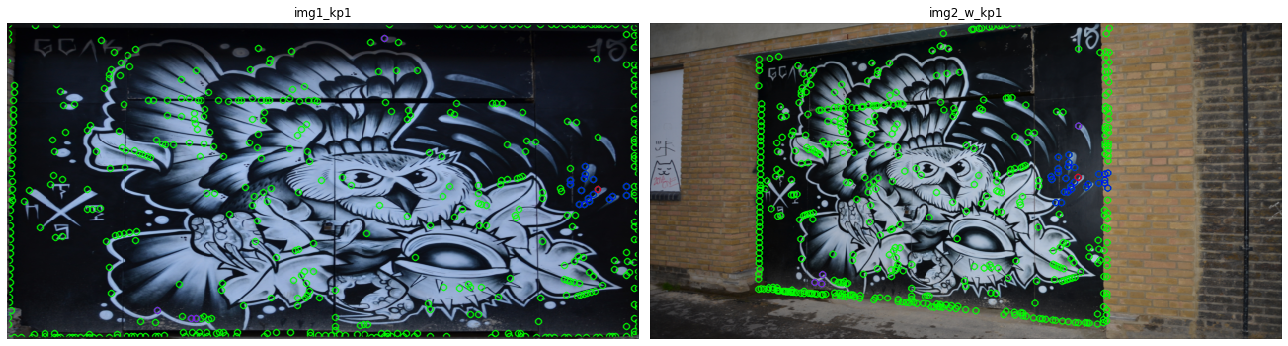

In [241]:
cv_w_kp1_image = draw_cv_keypoints(cv_s_image2, w_kp1.squeeze(0), (0, 255, 0))

res_image1 = draw_cv_keypoints(cv_kp1_image, kp_closest, (0, 0, 255))
res_image1 = draw_cv_keypoints(res_image1, kp1_hardest, (139, 0, 255))
res_image1 = draw_cv_keypoints(res_image1, kp1.squeeze(0)[None, kp_id], (255, 0, 0))

res_image2 = draw_cv_keypoints(cv_w_kp1_image, w_kp1_closest, (0, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_kp1_hardest, (139, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_kp1.squeeze(0)[None, kp_id], (255, 0, 0))

plot_figures({'img1_kp1': res_image1,
              'img2_w_kp1': res_image2}, 1, 2, (18, 9))